In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch
import albumentations as A
transform = A.load("/media/newhd/OPTRetina/DMAE/autoalbument-amd/outputs/2021-11-24/10-32-22/policy/latest.json")

In [2]:
torch.cuda.set_device(2)

In [3]:
df = pd.read_csv('../trainValid.csv')

In [4]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [5]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 224

In [6]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnet_224_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [21]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [22]:
dls = db.dataloaders(df.values,bs=128,num_workers=0)

In [23]:
learn = cnn_learner(dls,resnet50,
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.788980,0.441268,0.710256,0.726519,0.674359,0.699468,0.777176,01:36


Better model found at epoch 0 with f1_score value: 0.6994680851063829.


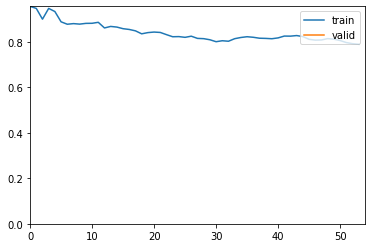

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.528916,0.295018,0.715385,0.744186,0.656410,0.697548,0.803327,01:40
1,0.474552,0.279474,0.732051,0.759312,0.679487,0.717185,0.812893,01:40
2,0.438611,0.216064,0.776923,0.813953,0.717949,0.762943,0.856811,01:39
3,0.411742,0.200991,0.757692,0.766578,0.741026,0.753585,0.858083,01:39
4,0.368011,0.186202,0.783333,0.850794,0.687179,0.760284,0.876420,01:39
5,0.336005,0.153975,0.780769,0.815562,0.725641,0.767978,0.877495,01:39
6,0.322156,0.140331,0.792308,0.820225,0.748718,0.782842,0.883416,01:39
7,0.282268,0.144159,0.803846,0.860182,0.725641,0.787204,0.883389,01:39
8,0.257014,0.129497,0.805128,0.878981,0.707692,0.784091,0.895056,01:39
9,0.230539,0.119334,0.788462,0.790698,0.784615,0.787645,0.883222,01:39


Better model found at epoch 0 with f1_score value: 0.6975476839237058.


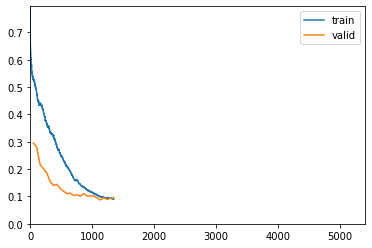

Better model found at epoch 1 with f1_score value: 0.7171853856562923.
Better model found at epoch 2 with f1_score value: 0.7629427792915531.
Better model found at epoch 5 with f1_score value: 0.76797829036635.
Better model found at epoch 6 with f1_score value: 0.7828418230563002.
Better model found at epoch 7 with f1_score value: 0.7872044506258693.
Better model found at epoch 9 with f1_score value: 0.7876447876447876.
Better model found at epoch 12 with f1_score value: 0.8081632653061225.
Better model found at epoch 16 with f1_score value: 0.8255959849435383.
Better model found at epoch 20 with f1_score value: 0.8258064516129032.
Better model found at epoch 22 with f1_score value: 0.8412903225806452.
No improvement since epoch 20: early stopping


In [24]:
learn.fine_tune(100,base_lr=1e-3)

In [25]:
dfTest = pd.read_csv('../testSample.csv')

In [26]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [27]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [28]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [29]:
learn.dls = dlsTest

In [30]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9592026298487837.


(#6) [0.06941656768321991,0.8984615206718445,0.9093782929399368,0.8851282051282051,0.8970893970893971,0.9592026298487837]

# 384

In [31]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnet50_384_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [32]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [33]:
dls = db.dataloaders(df.values,bs=32,num_workers=0)

In [38]:
learn = cnn_learner(dls,resnet50,
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [39]:
learn.load('resnet_224_b')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=0.0003981071640737355)

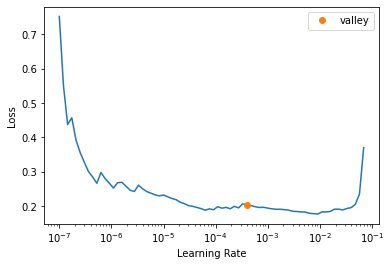

In [40]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.167611,0.195357,0.758974,0.724444,0.835897,0.776190,0.778652,01:54


Better model found at epoch 0 with f1_score value: 0.7761904761904761.


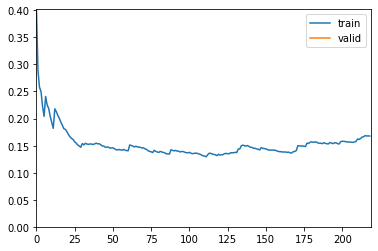

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.123021,0.111469,0.823077,0.943662,0.687179,0.795252,0.918379,02:08
1,0.107914,0.088123,0.833333,0.808057,0.874359,0.839901,0.928876,02:07
2,0.104651,0.087515,0.838462,0.890533,0.771795,0.826923,0.933478,02:07
3,0.100551,0.090082,0.832051,0.893617,0.753846,0.817803,0.931315,02:07
4,0.102708,0.088116,0.842308,0.884726,0.787179,0.833107,0.932048,02:07
5,0.099254,0.089916,0.847436,0.839599,0.858974,0.849176,0.932403,02:07
6,0.101109,0.093979,0.850000,0.886686,0.802564,0.842530,0.923974,02:07
7,0.095497,0.088378,0.839744,0.879656,0.787179,0.830853,0.932597,02:07


Better model found at epoch 0 with f1_score value: 0.795252225519288.


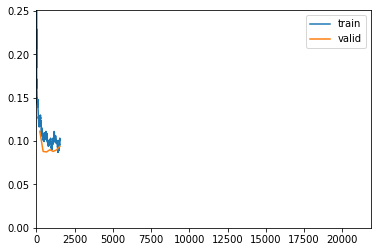

Better model found at epoch 1 with f1_score value: 0.8399014778325123.
Better model found at epoch 5 with f1_score value: 0.8491761723700887.
No improvement since epoch 2: early stopping


In [41]:
learn.fine_tune(100,base_lr=3e-3)

In [42]:
dfTest = pd.read_csv('../testSample.csv')

In [43]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [44]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [45]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [46]:
learn.dls = dlsTest

In [47]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9587881656804734.


(#6) [0.07271213829517365,0.9123076796531677,0.9161490683229814,0.9076923076923077,0.911901081916538,0.9587881656804734]

# 512

In [48]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnet50_512_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [49]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [50]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [51]:
learn = cnn_learner(dls,resnet50,
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [52]:
learn.load('resnet50_384_b')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=0.0005754399462603033)

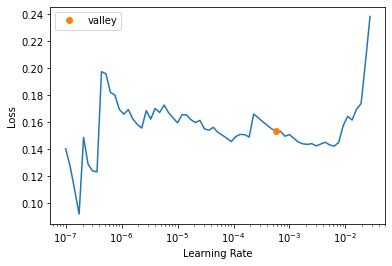

In [53]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.240596,0.120952,0.798718,0.849850,0.725641,0.782849,0.908113,03:17


Better model found at epoch 0 with f1_score value: 0.7828492392807744.


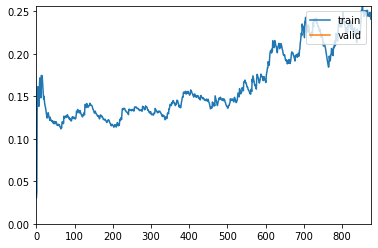

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.161665,0.110966,0.814103,0.823219,0.800000,0.811443,0.906792,03:48
1,0.121239,0.094586,0.823077,0.838710,0.800000,0.818898,0.917396,03:48
2,0.121004,0.114339,0.778205,0.774684,0.784615,0.779618,0.874175,03:48
3,0.116047,0.093395,0.830769,0.813107,0.858974,0.835411,0.921986,03:48
4,0.107117,0.103563,0.821795,0.859599,0.769231,0.811908,0.890792,03:47
5,0.118568,0.084728,0.861538,0.838942,0.894872,0.866005,0.940661,03:48
6,0.119085,0.093913,0.842308,0.834586,0.853846,0.844106,0.923340,03:48
7,0.122621,0.093510,0.838462,0.811321,0.882051,0.845209,0.927472,03:48
8,0.112772,0.090063,0.820513,0.836022,0.797436,0.816273,0.927446,03:49
9,0.126871,0.091411,0.829487,0.786192,0.905128,0.841478,0.928323,03:48


Better model found at epoch 0 with f1_score value: 0.8114434330299091.


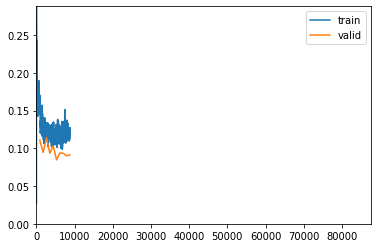

Better model found at epoch 1 with f1_score value: 0.8188976377952757.
Better model found at epoch 3 with f1_score value: 0.8354114713216958.
Better model found at epoch 5 with f1_score value: 0.8660049627791563.
No improvement since epoch 5: early stopping


In [54]:
learn.fine_tune(100,base_lr=3e-3)

In [55]:
dfTest = pd.read_csv('../testSample.csv')

In [56]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [57]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [58]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=8,num_workers=0)

In [59]:
learn.dls = dlsTest

In [60]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9554303747534518.


(#6) [0.0728657990694046,0.9025641083717346,0.9084287200832466,0.8953846153846153,0.9018595041322314,0.9554303747534518]